수집 대상 분기: ['20221', '20222', '20223', '20224', '20231', '20232', '20233', '20234', '20241', '20242', '20243', '20244', '20251', '20252', '20253', '20254']

서울시 상권분석 API 데이터 수집 시작
수집 중: 1~1,000 / 전체 458,616건 (현재 1,000건)
수집 중: 1,001~2,000 / 전체 458,616건 (현재 2,000건)
수집 중: 2,001~3,000 / 전체 458,616건 (현재 3,000건)
수집 중: 3,001~4,000 / 전체 458,616건 (현재 4,000건)
수집 중: 4,001~5,000 / 전체 458,616건 (현재 5,000건)
수집 중: 5,001~6,000 / 전체 458,616건 (현재 6,000건)
수집 중: 6,001~7,000 / 전체 458,616건 (현재 7,000건)
수집 중: 7,001~8,000 / 전체 458,616건 (현재 8,000건)
수집 중: 8,001~9,000 / 전체 458,616건 (현재 9,000건)
수집 중: 9,001~10,000 / 전체 458,616건 (현재 10,000건)
수집 중: 10,001~11,000 / 전체 458,616건 (현재 11,000건)
수집 중: 11,001~12,000 / 전체 458,616건 (현재 12,000건)
수집 중: 12,001~13,000 / 전체 458,616건 (현재 13,000건)
수집 중: 13,001~14,000 / 전체 458,616건 (현재 14,000건)
수집 중: 14,001~15,000 / 전체 458,616건 (현재 15,000건)
수집 중: 15,001~16,000 / 전체 458,616건 (현재 16,000건)
수집 중: 16,001~17,000 / 전체 458,616건 (현재 17,000건)
수집 중: 17,001~18,000 / 전체 458,616건 (현재 18,000건)
수집 중: 1

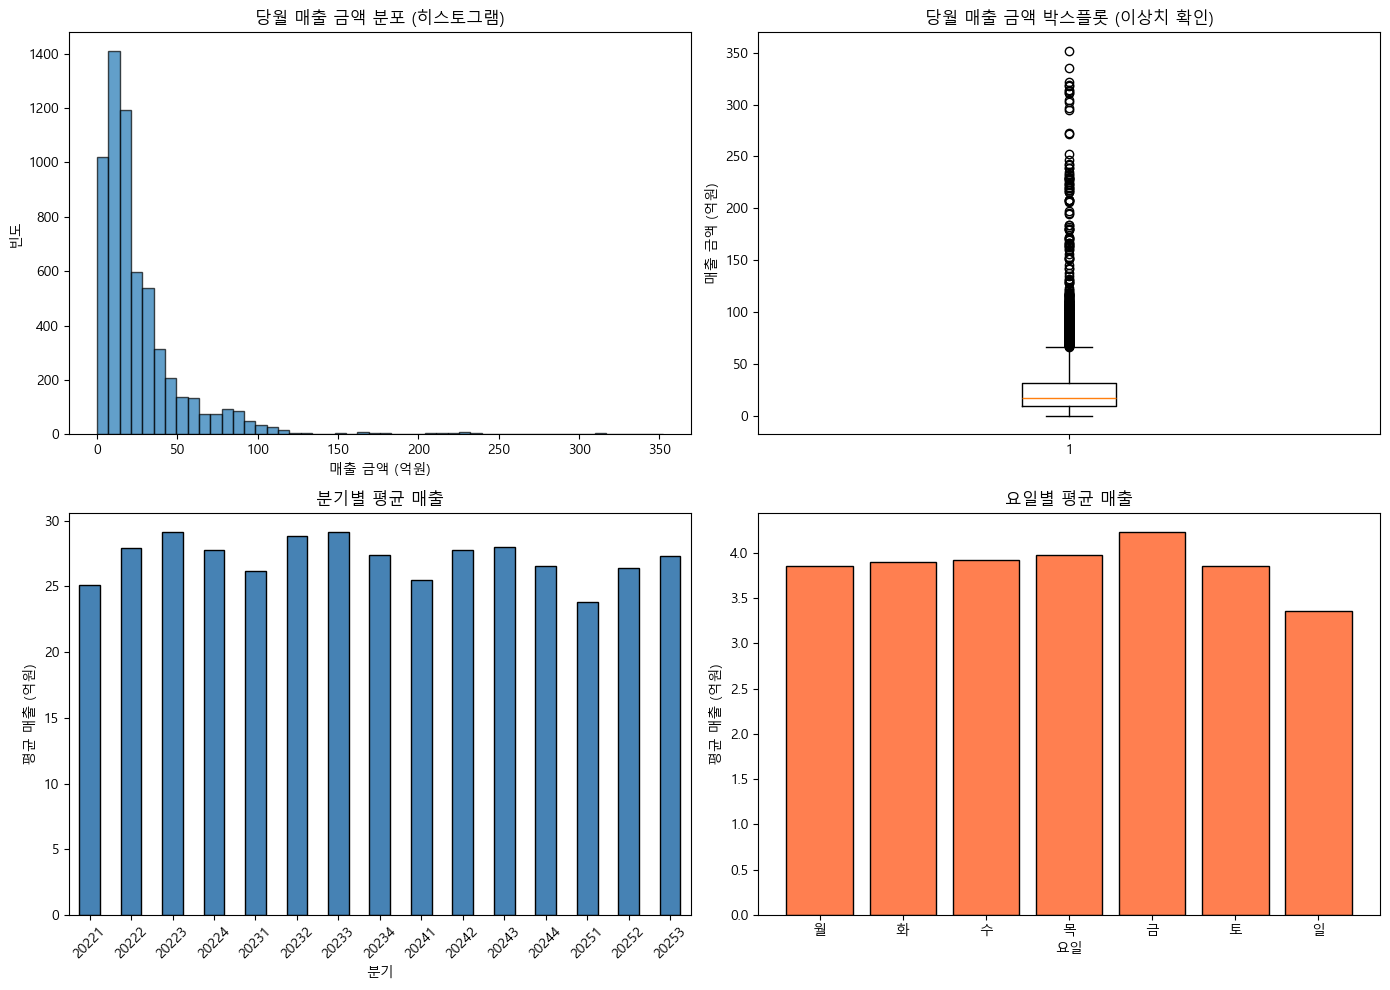

✅ 시각화 저장 완료: eda_시각화.png

📌 4단계: 이상한 점 발견하기

[4-1] 매출이 0원인 데이터
----------------------------------------
매출 0원 데이터: 0건 (0.00%)

[4-2] 매출이 음수인 데이터
----------------------------------------
매출 음수 데이터: 0건
✅ 음수 매출 없음!

[4-3] 중복 데이터 확인
----------------------------------------
전체 행 중복: 0건
행정동+분기 기준 중복: 0건

[4-4] 이상치 확인 (당월_매출_금액 - IQR 방식)
----------------------------------------
Q1 (25%): 947,625,957원
Q3 (75%): 3,234,061,370원
IQR: 2,286,435,413원
하한 경계: -2,482,027,162원
상한 경계: 6,663,714,490원

[하한 이상치] 매출 < -2,482,027,162원: 0건

[상한 이상치] 매출 > 6,663,714,490원: 512건

⚠️ 상한 이상치 샘플 (매출이 너무 높음) - 상위 10개:
행정동_코드_명 기준_년분기_코드                 당월_매출_금액
    역삼1동     20233 35,191,306,523원 (351.9억)
    역삼1동     20232 33,529,108,281원 (335.3억)
    역삼1동     20224 32,142,050,952원 (321.4억)
    역삼1동     20223 31,850,596,764원 (318.5억)
    역삼1동     20243 31,782,527,446원 (317.8억)
    역삼1동     20253 31,364,117,463원 (313.6억)
    역삼1동     20242 31,300,673,670원 (313.0억)
    역삼1동     20234 31,141,460,490원 (311.4억)
    역삼1동  

In [2]:
"""
서울시 우리마을가게 상권분석서비스 - 행정동별 매출금액 API 호출
- 기간: 2022년 ~ 2025년 (분기별)
- 업종: 편의점 (CS300002)
- 서비스명: VwsmAdstrdSelngW
+ EDA (탐색적 데이터 분석) 포함 - 이상치/이상 데이터 상세 확인 버전
"""
pd.set_option('display.max_rows', None)  # 행 제한 해제
pd.set_option('display.max_columns', None)  # 열 제한 해제
pd.set_option('display.width', None)  # 너비 제한 해제

import requests
import pandas as pd
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
# plt.rcParams['font.family'] = 'AppleGothic'  # Mac
plt.rcParams['axes.unicode_minus'] = False

# ============================================================
# 설정
# ============================================================
API_KEY = "4a5a5a4c7768666f3634687355484f"
SERVICE_NAME = "VwsmAdstrdSelngW"
BASE_URL = f"http://openapi.seoul.go.kr:8088/{API_KEY}/json/{SERVICE_NAME}"

CONVENIENCE_STORE_CODE = "CS300002"

def generate_quarter_codes(start_year=2022, end_year=2025):
    codes = []
    for year in range(start_year, end_year + 1):
        for quarter in range(1, 5):
            codes.append(f"{year}{quarter}")
    return codes

QUARTER_CODES = generate_quarter_codes(2022, 2025)
print(f"수집 대상 분기: {QUARTER_CODES}")


# ============================================================
# API 호출 함수
# ============================================================
def fetch_all_data():
    all_data = []
    start = 1
    batch_size = 1000
    
    print(f"\n{'='*60}")
    print("서울시 상권분석 API 데이터 수집 시작")
    print(f"{'='*60}")
    
    while True:
        end = start + batch_size - 1
        url = f"{BASE_URL}/{start}/{end}"
        
        try:
            response = requests.get(url, timeout=30)
            response.raise_for_status()
            result = response.json()
            
            if SERVICE_NAME not in result:
                if 'RESULT' in result:
                    print(f"API 에러: {result['RESULT']}")
                break
            
            code = result[SERVICE_NAME]['RESULT']['CODE']
            if code != 'INFO-000':
                print(f"API 응답 코드: {code}")
                break
            
            rows = result[SERVICE_NAME].get('row', [])
            if not rows:
                print("더 이상 데이터가 없습니다.")
                break
            
            all_data.extend(rows)
            total_count = result[SERVICE_NAME]['list_total_count']
            
            print(f"수집 중: {start:,}~{end:,} / 전체 {total_count:,}건 (현재 {len(all_data):,}건)")
            
            if len(all_data) >= total_count:
                print(f"\n전체 데이터 수집 완료: {len(all_data):,}건")
                break
            
            start += batch_size
            time.sleep(0.5)
            
        except requests.exceptions.RequestException as e:
            print(f"요청 에러 (start={start}): {e}")
            time.sleep(2)
            continue
        except Exception as e:
            print(f"처리 에러: {e}")
            break
    
    return all_data


def filter_convenience_store(data, quarter_codes=None):
    df = pd.DataFrame(data)
    df_conv = df[df['SVC_INDUTY_CD'] == CONVENIENCE_STORE_CODE].copy()
    print(f"\n편의점 데이터: {len(df_conv):,}건")
    
    if quarter_codes:
        df_conv['STDR_YYQU_CD'] = df_conv['STDR_YYQU_CD'].astype(str)
        df_conv = df_conv[df_conv['STDR_YYQU_CD'].isin(quarter_codes)]
        print(f"2022~2025년 데이터: {len(df_conv):,}건")
    
    return df_conv


# ============================================================
# 컬럼명 한글 변환
# ============================================================
COLUMN_MAPPING = {
    'STDR_YYQU_CD': '기준_년분기_코드',
    'ADSTRD_CD': '행정동_코드',
    'ADSTRD_CD_NM': '행정동_코드_명',
    'SVC_INDUTY_CD': '서비스_업종_코드',
    'SVC_INDUTY_CD_NM': '서비스_업종_코드_명',
    'THSMON_SELNG_AMT': '당월_매출_금액',
    'THSMON_SELNG_CO': '당월_매출_건수',
    'MDWK_SELNG_AMT': '주중_매출_금액',
    'WKEND_SELNG_AMT': '주말_매출_금액',
    'MON_SELNG_AMT': '월요일_매출_금액',
    'TUES_SELNG_AMT': '화요일_매출_금액',
    'WED_SELNG_AMT': '수요일_매출_금액',
    'THUR_SELNG_AMT': '목요일_매출_금액',
    'FRI_SELNG_AMT': '금요일_매출_금액',
    'SAT_SELNG_AMT': '토요일_매출_금액',
    'SUN_SELNG_AMT': '일요일_매출_금액',
    'TMZON_00_06_SELNG_AMT': '시간대_00~06_매출_금액',
    'TMZON_06_11_SELNG_AMT': '시간대_06~11_매출_금액',
    'TMZON_11_14_SELNG_AMT': '시간대_11~14_매출_금액',
    'TMZON_14_17_SELNG_AMT': '시간대_14~17_매출_금액',
    'TMZON_17_21_SELNG_AMT': '시간대_17~21_매출_금액',
    'TMZON_21_24_SELNG_AMT': '시간대_21~24_매출_금액',
    'ML_SELNG_AMT': '남성_매출_금액',
    'FML_SELNG_AMT': '여성_매출_금액',
    'AGRDE_10_SELNG_AMT': '연령대_10_매출_금액',
    'AGRDE_20_SELNG_AMT': '연령대_20_매출_금액',
    'AGRDE_30_SELNG_AMT': '연령대_30_매출_금액',
    'AGRDE_40_SELNG_AMT': '연령대_40_매출_금액',
    'AGRDE_50_SELNG_AMT': '연령대_50_매출_금액',
    'AGRDE_60_ABOVE_SELNG_AMT': '연령대_60_이상_매출_금액',
    'MDWK_SELNG_CO': '주중_매출_건수',
    'WKEND_SELNG_CO': '주말_매출_건수',
    'MON_SELNG_CO': '월요일_매출_건수',
    'TUES_SELNG_CO': '화요일_매출_건수',
    'WED_SELNG_CO': '수요일_매출_건수',
    'THUR_SELNG_CO': '목요일_매출_건수',
    'FRI_SELNG_CO': '금요일_매출_건수',
    'SAT_SELNG_CO': '토요일_매출_건수',
    'SUN_SELNG_CO': '일요일_매출_건수',
    'TMZON_00_06_SELNG_CO': '시간대_00~06_매출_건수',
    'TMZON_06_11_SELNG_CO': '시간대_06~11_매출_건수',
    'TMZON_11_14_SELNG_CO': '시간대_11~14_매출_건수',
    'TMZON_14_17_SELNG_CO': '시간대_14~17_매출_건수',
    'TMZON_17_21_SELNG_CO': '시간대_17~21_매출_건수',
    'TMZON_21_24_SELNG_CO': '시간대_21~24_매출_건수',
    'ML_SELNG_CO': '남성_매출_건수',
    'FML_SELNG_CO': '여성_매출_건수',
    'AGRDE_10_SELNG_CO': '연령대_10_매출_건수',
    'AGRDE_20_SELNG_CO': '연령대_20_매출_건수',
    'AGRDE_30_SELNG_CO': '연령대_30_매출_건수',
    'AGRDE_40_SELNG_CO': '연령대_40_매출_건수',
    'AGRDE_50_SELNG_CO': '연령대_50_매출_건수',
    'AGRDE_60_ABOVE_SELNG_CO': '연령대_60_이상_매출_건수',
}


# ============================================================
# EDA 함수 (이상치/이상 데이터 상세 확인 버전)
# ============================================================
def run_eda(df):
    """
    탐색적 데이터 분석 (EDA) 수행
    - 이상치와 이상 데이터를 상세히 확인할 수 있도록 구성
    """
    print(f"\n{'='*60}")
    print("📊 EDA (탐색적 데이터 분석) 시작")
    print(f"{'='*60}")
    
    # =========================================================
    # 1단계: 데이터 훑어보기
    # =========================================================
    print(f"\n{'='*60}")
    print("📌 1단계: 데이터 훑어보기")
    print(f"{'='*60}")
    
    # 1-1. 데이터 크기
    print("\n[1-1] 데이터 크기")
    print("-" * 40)
    print(f"행 개수: {df.shape[0]:,}개")
    print(f"열 개수: {df.shape[1]}개")
    
    # 1-2. 컬럼 목록
    print("\n[1-2] 컬럼 목록")
    print("-" * 40)
    for i, col in enumerate(df.columns, 1):
        print(f"  {i:2}. {col}")
    
    # 1-3. 데이터 타입
    print("\n[1-3] 데이터 타입")
    print("-" * 40)
    print(df.dtypes)
    
    # 1-4. 상위 5개 행 미리보기
    print("\n[1-4] 상위 5개 행 미리보기")
    print("-" * 40)
    print(df.head())
    
    # 1-5. 결측치 확인
    print("\n[1-5] 결측치 확인")
    print("-" * 40)
    missing = df.isnull().sum()
    missing_pct = (missing / len(df) * 100).round(2)
    missing_df = pd.DataFrame({'결측치 수': missing, '결측치 비율(%)': missing_pct})
    missing_with_values = missing_df[missing_df['결측치 수'] > 0]
    
    if len(missing_with_values) > 0:
        print(missing_with_values)
        print("\n⚠️ 결측치가 있는 행 샘플:")
        for col in missing_with_values.index:
            print(f"\n  [{col}] 결측치 샘플 (최대 5개):")
            sample = df[df[col].isnull()][['행정동_코드_명', '기준_년분기_코드', col]].head()
            print(sample.to_string(index=False))
    else:
        print("✅ 결측치 없음!")
    
    # =========================================================
    # 2단계: 숫자 요약하기
    # =========================================================
    print(f"\n{'='*60}")
    print("📌 2단계: 숫자 요약하기")
    print(f"{'='*60}")
    
    # 2-1. 주요 컬럼 기초 통계량
    print("\n[2-1] 기초 통계량 (당월_매출_금액)")
    print("-" * 40)
    if '당월_매출_금액' in df.columns:
        stats = df['당월_매출_금액'].describe()
        print(f"개수: {stats['count']:,.0f}개")
        print(f"평균: {stats['mean']:,.0f}원 ({stats['mean']/1e8:.2f}억원)")
        print(f"최소: {stats['min']:,.0f}원")
        print(f"최대: {stats['max']:,.0f}원 ({stats['max']/1e8:.2f}억원)")
        print(f"중앙값: {stats['50%']:,.0f}원")
        print(f"표준편차: {stats['std']:,.0f}원")
    
    # =========================================================
    # 3단계: 그래프로 보기
    # =========================================================
    print(f"\n{'='*60}")
    print("📌 3단계: 그래프로 보기")
    print(f"{'='*60}")
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 3-1. 히스토그램
    if '당월_매출_금액' in df.columns:
        axes[0, 0].hist(df['당월_매출_금액'] / 1e8, bins=50, edgecolor='black', alpha=0.7)
        axes[0, 0].set_title('당월 매출 금액 분포 (히스토그램)', fontsize=12)
        axes[0, 0].set_xlabel('매출 금액 (억원)')
        axes[0, 0].set_ylabel('빈도')
    
    # 3-2. 박스플롯
    if '당월_매출_금액' in df.columns:
        axes[0, 1].boxplot(df['당월_매출_금액'] / 1e8, vert=True)
        axes[0, 1].set_title('당월 매출 금액 박스플롯 (이상치 확인)', fontsize=12)
        axes[0, 1].set_ylabel('매출 금액 (억원)')
    
    # 3-3. 분기별 평균 매출 추이
    if '기준_년분기_코드' in df.columns and '당월_매출_금액' in df.columns:
        quarterly_avg = df.groupby('기준_년분기_코드')['당월_매출_금액'].mean() / 1e8
        quarterly_avg.plot(kind='bar', ax=axes[1, 0], color='steelblue', edgecolor='black')
        axes[1, 0].set_title('분기별 평균 매출', fontsize=12)
        axes[1, 0].set_xlabel('분기')
        axes[1, 0].set_ylabel('평균 매출 (억원)')
        axes[1, 0].tick_params(axis='x', rotation=45)
    
    # 3-4. 요일별 매출 비교
    day_cols = ['월요일_매출_금액', '화요일_매출_금액', '수요일_매출_금액', 
                '목요일_매출_금액', '금요일_매출_금액', '토요일_매출_금액', '일요일_매출_금액']
    day_cols = [col for col in day_cols if col in df.columns]
    if day_cols:
        day_means = df[day_cols].mean() / 1e8
        day_labels = ['월', '화', '수', '목', '금', '토', '일']
        axes[1, 1].bar(day_labels, day_means, color='coral', edgecolor='black')
        axes[1, 1].set_title('요일별 평균 매출', fontsize=12)
        axes[1, 1].set_xlabel('요일')
        axes[1, 1].set_ylabel('평균 매출 (억원)')
    
    plt.tight_layout()
    plt.savefig('eda_시각화.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✅ 시각화 저장 완료: eda_시각화.png")
    
    # =========================================================
    # 4단계: 이상한 점 발견하기
    # =========================================================
    print(f"\n{'='*60}")
    print("📌 4단계: 이상한 점 발견하기")
    print(f"{'='*60}")
    
    # ---------------------------------------------------------
    # 4-1. 매출이 0원인 데이터
    # ---------------------------------------------------------
    print("\n[4-1] 매출이 0원인 데이터")
    print("-" * 40)
    if '당월_매출_금액' in df.columns:
        zero_sales = df[df['당월_매출_금액'] == 0]
        print(f"매출 0원 데이터: {len(zero_sales):,}건 ({len(zero_sales)/len(df)*100:.2f}%)")
        
        if len(zero_sales) > 0:
            print("\n⚠️ 매출 0원인 행정동 샘플 (최대 10개):")
            print(zero_sales[['행정동_코드_명', '기준_년분기_코드', '당월_매출_금액']].head(10).to_string(index=False))
            
            print("\n📍 매출 0원이 많은 행정동 TOP 5:")
            zero_by_dong = zero_sales['행정동_코드_명'].value_counts().head(5)
            for dong, cnt in zero_by_dong.items():
                print(f"  - {dong}: {cnt}건")
    
    # ---------------------------------------------------------
    # 4-2. 매출이 음수인 데이터
    # ---------------------------------------------------------
    print("\n[4-2] 매출이 음수인 데이터")
    print("-" * 40)
    if '당월_매출_금액' in df.columns:
        negative_sales = df[df['당월_매출_금액'] < 0]
        print(f"매출 음수 데이터: {len(negative_sales):,}건")
        
        if len(negative_sales) > 0:
            print("\n⚠️ 매출 음수인 행정동 (전체):")
            print(negative_sales[['행정동_코드_명', '기준_년분기_코드', '당월_매출_금액']].to_string(index=False))
        else:
            print("✅ 음수 매출 없음!")
    
    # ---------------------------------------------------------
    # 4-3. 중복 데이터 확인
    # ---------------------------------------------------------
    print("\n[4-3] 중복 데이터 확인")
    print("-" * 40)
    
    # 전체 행 중복
    dup_all = df.duplicated().sum()
    print(f"전체 행 중복: {dup_all:,}건")
    
    # 행정동+분기 기준 중복 (같은 행정동, 같은 분기에 2개 이상)
    if '행정동_코드' in df.columns and '기준_년분기_코드' in df.columns:
        dup_key = df.duplicated(subset=['행정동_코드', '기준_년분기_코드'], keep=False)
        dup_data = df[dup_key]
        print(f"행정동+분기 기준 중복: {len(dup_data):,}건")
        
        if len(dup_data) > 0:
            print("\n⚠️ 중복된 행정동+분기 샘플:")
            sample = dup_data.groupby(['행정동_코드_명', '기준_년분기_코드']).size().reset_index(name='중복횟수')
            sample = sample[sample['중복횟수'] > 1].head(10)
            print(sample.to_string(index=False))
    
    # ---------------------------------------------------------
    # 4-4. 이상치 확인 (IQR 방식)
    # ---------------------------------------------------------
    print("\n[4-4] 이상치 확인 (당월_매출_금액 - IQR 방식)")
    print("-" * 40)
    if '당월_매출_금액' in df.columns:
        q1 = df['당월_매출_금액'].quantile(0.25)
        q3 = df['당월_매출_금액'].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        
        print(f"Q1 (25%): {q1:,.0f}원")
        print(f"Q3 (75%): {q3:,.0f}원")
        print(f"IQR: {iqr:,.0f}원")
        print(f"하한 경계: {lower:,.0f}원")
        print(f"상한 경계: {upper:,.0f}원")
        
        # 하한 이상치 (너무 낮은 매출)
        outliers_low = df[df['당월_매출_금액'] < lower]
        print(f"\n[하한 이상치] 매출 < {lower:,.0f}원: {len(outliers_low):,}건")
        
        if len(outliers_low) > 0:
            print("\n⚠️ 하한 이상치 샘플 (매출이 너무 낮음) - 상위 10개:")
            low_sample = outliers_low.nsmallest(10, '당월_매출_금액')[['행정동_코드_명', '기준_년분기_코드', '당월_매출_금액']]
            low_sample['당월_매출_금액'] = low_sample['당월_매출_금액'].apply(lambda x: f"{x:,.0f}원")
            print(low_sample.to_string(index=False))
            
            print("\n📍 하한 이상치가 많은 행정동 TOP 5:")
            low_by_dong = outliers_low['행정동_코드_명'].value_counts().head(5)
            for dong, cnt in low_by_dong.items():
                print(f"  - {dong}: {cnt}건")
        
        # 상한 이상치 (너무 높은 매출)
        outliers_high = df[df['당월_매출_금액'] > upper]
        print(f"\n[상한 이상치] 매출 > {upper:,.0f}원: {len(outliers_high):,}건")
        
        if len(outliers_high) > 0:
            print("\n⚠️ 상한 이상치 샘플 (매출이 너무 높음) - 상위 10개:")
            high_sample = outliers_high.nlargest(10, '당월_매출_금액')[['행정동_코드_명', '기준_년분기_코드', '당월_매출_금액']]
            high_sample['당월_매출_금액'] = high_sample['당월_매출_금액'].apply(lambda x: f"{x:,.0f}원 ({x/1e8:.1f}억)")
            print(high_sample.to_string(index=False))
            
            print("\n📍 상한 이상치가 많은 행정동 TOP 5:")
            high_by_dong = outliers_high['행정동_코드_명'].value_counts().head(5)
            for dong, cnt in high_by_dong.items():
                print(f"  - {dong}: {cnt}건")
        
        # 이상치 전체 요약
        total_outliers = len(outliers_low) + len(outliers_high)
        print(f"\n📊 이상치 요약:")
        print(f"  - 하한 이상치: {len(outliers_low):,}건")
        print(f"  - 상한 이상치: {len(outliers_high):,}건")
        print(f"  - 전체 이상치: {total_outliers:,}건 ({total_outliers/len(df)*100:.1f}%)")
    
    # ---------------------------------------------------------
    # 4-5. 분기별 데이터 누락 확인
    # ---------------------------------------------------------
    print("\n[4-5] 분기별 데이터 건수 확인")
    print("-" * 40)
    if '기준_년분기_코드' in df.columns:
        quarter_counts = df.groupby('기준_년분기_코드').size().sort_index()
        print(quarter_counts)
        
        # 분기별 편차 확인
        avg_count = quarter_counts.mean()
        print(f"\n분기 평균 데이터 수: {avg_count:.0f}건")
        
        abnormal_quarters = quarter_counts[abs(quarter_counts - avg_count) > avg_count * 0.2]
        if len(abnormal_quarters) > 0:
            print("\n⚠️ 평균 대비 ±20% 이상 차이나는 분기:")
            for q, cnt in abnormal_quarters.items():
                diff_pct = (cnt - avg_count) / avg_count * 100
                print(f"  - {q}: {cnt}건 ({diff_pct:+.1f}%)")
    
    # =========================================================
    # EDA 요약
    # =========================================================
    print(f"\n{'='*60}")
    print("📊 EDA 요약")
    print(f"{'='*60}")
    print(f"총 데이터: {len(df):,}건")
    print(f"행정동 수: {df['행정동_코드_명'].nunique()}개")
    print(f"분기 수: {df['기준_년분기_코드'].nunique()}개")
    
    issues = []
    if len(missing_with_values) > 0:
        issues.append(f"결측치 있음")
    if '당월_매출_금액' in df.columns and len(df[df['당월_매출_금액'] == 0]) > 0:
        issues.append(f"매출 0원: {len(df[df['당월_매출_금액'] == 0]):,}건")
    if '당월_매출_금액' in df.columns and len(df[df['당월_매출_금액'] < 0]) > 0:
        issues.append(f"매출 음수: {len(df[df['당월_매출_금액'] < 0]):,}건")
    if dup_all > 0:
        issues.append(f"중복 행: {dup_all:,}건")
    if '당월_매출_금액' in df.columns:
        issues.append(f"이상치: {total_outliers:,}건")
    
    if issues:
        print(f"\n⚠️ 발견된 이슈:")
        for issue in issues:
            print(f"  - {issue}")
    else:
        print("\n✅ 특별한 이슈 없음!")
    
    print(f"\n{'='*60}")
    print("📊 EDA 완료!")
    print(f"{'='*60}")
    
    return df


# ============================================================
# 메인 실행
# ============================================================
if __name__ == "__main__":
    if API_KEY == "YOUR_API_KEY_HERE":
        print("⚠️  API_KEY를 설정해주세요!")
        API_KEY = "sample"
        BASE_URL = f"http://openapi.seoul.go.kr:8088/{API_KEY}/json/{SERVICE_NAME}"
    
    raw_data = fetch_all_data()
    
    if raw_data:
        df_result = filter_convenience_store(raw_data, QUARTER_CODES)
        
        if len(df_result) > 0:
            df_result = df_result.rename(columns=COLUMN_MAPPING)
            
            numeric_cols = [col for col in df_result.columns if '금액' in col or '건수' in col]
            for col in numeric_cols:
                df_result[col] = pd.to_numeric(df_result[col], errors='coerce')
            
            output_file = "서울시_편의점_매출_2022_2025.csv"
            df_result.to_csv(output_file, index=False, encoding='utf-8-sig')
            print(f"\n✅ 저장 완료: {output_file}")
            
            # EDA 실행
            df_result = run_eda(df_result)
            
        else:
            print("편의점 데이터가 없습니다.")
    else:
        print("데이터 수집 실패")

In [ ]:

# ## 1. 당월 매출 금액 분포 (히스토그램) - 왼쪽 위

# **결과:**
# - 대부분의 행정동 매출이 **0~50억원**에 몰려 있음
# - **오른쪽으로 긴 꼬리** (Right-skewed) → 소수의 행정동만 매출이 매우 높음
# - 매출 100억 이상인 행정동은 극소수

# **해석:** 서울 편의점 매출은 **양극화**되어 있음. 대부분은 낮은 매출, 일부 핫플레이스만 고매출.

# ---

# ## 2. 당월 매출 금액 박스플롯 (이상치 확인) - 오른쪽 위

# **결과:**
# - 박스(중간 50%) 자체는 **0~25억 정도**로 좁음
# - **위쪽에 점이 엄청 많음** → 상한 이상치가 많다는 뜻
# - 최대 350억원까지 있음

# **해석:** 이상치가 많지만, 이게 진짜 "이상한 데이터"가 아니라 **명동, 강남역 같은 고매출 상권**일 가능성 높음. 제거할지 유지할지는 분석 목적에 따라 결정해야 함.

# ---

# ## 3. 분기별 평균 매출 - 왼쪽 아래

# **결과:**
# - 대체로 **25~29억원** 사이로 안정적
# - **2022년 1분기**가 약간 낮음 (코로나 영향?)
# - **2025년 1분기**도 낮음 (데이터 수집 시점 문제일 수 있음)

# **해석:** 전체적으로 **큰 변동 없이 안정적**. 계절성이나 특별한 트렌드는 뚜렷하지 않음.

# ---

# ## 4. 요일별 평균 매출 - 오른쪽 아래

# **결과:**
# - **금요일**이 가장 높음 (~4.2억)
# - **일요일**이 가장 낮음 (~3.4억)
# - 월~목은 비슷한 수준 (~3.9억)

# **해석:** 주말 전날인 금요일에 매출 UP, 일요일은 사람들이 쉬니까 DOWN. **편의점도 요일별 패턴이 있음**.

# ---

# ## 전체 요약

# | 항목 | 발견 |
# |------|------|
# | 분포 | 오른쪽 꼬리 분포 (대부분 저매출, 소수 고매출) |
# | 이상치 | 상한 이상치 많음 (고매출 상권) |
# | 시간 추이 | 분기별로 큰 변화 없음 (안정적) |
# | 요일 패턴 | 금요일 최고, 일요일 최저 |

In [6]:
# 이상치 행정동 직접 확인하기

# 1. 이상치 기준 계산
q1 = df_result['당월_매출_금액'].quantile(0.25)
q3 = df_result['당월_매출_금액'].quantile(0.75)
iqr = q3 - q1
upper = q3 + 1.5 * iqr

print(f"상한 기준: {upper:,.0f}원 ({upper/1e8:.1f}억원)")

# 2. 상한 이상치 추출
outliers_high = df_result[df_result['당월_매출_금액'] > upper]
print(f"상한 이상치 개수: {len(outliers_high)}건")

# 3. 고매출 상위 20개 행정동 확인
print("\n📍 고매출 TOP 20 (이상치에 해당하는 행정동):")
top20 = outliers_high.nlargest(20, '당월_매출_금액')[['행정동_코드_명', '기준_년분기_코드', '당월_매출_금액']]
top20['매출(억원)'] = (top20['당월_매출_금액'] / 1e8).round(1)
print(top20.to_string(index=False))

# 4. 이상치가 많이 나오는 행정동 TOP 10
print("\n📍 이상치 빈도 TOP 10 (어떤 행정동이 자주 이상치로 잡히나):")
freq = outliers_high['행정동_코드_명'].value_counts().head(10)
for dong, cnt in freq.items():
    print(f"  - {dong}: {cnt}건")

상한 기준: 6,663,714,490원 (66.6억원)
상한 이상치 개수: 512건

📍 고매출 TOP 20 (이상치에 해당하는 행정동):
행정동_코드_명 기준_년분기_코드     당월_매출_금액  매출(억원)
    역삼1동     20233 3.519131e+10   351.9
    역삼1동     20232 3.352911e+10   335.3
    역삼1동     20224 3.214205e+10   321.4
    역삼1동     20223 3.185060e+10   318.5
    역삼1동     20243 3.178253e+10   317.8
    역삼1동     20253 3.136412e+10   313.6
    역삼1동     20242 3.130067e+10   313.0
    역삼1동     20234 3.114146e+10   311.4
    역삼1동     20231 3.111126e+10   311.1
    역삼1동     20222 3.042236e+10   304.2
    역삼1동     20241 3.023844e+10   302.4
    역삼1동     20244 2.968038e+10   296.8
    역삼1동     20252 2.947112e+10   294.7
    역삼1동     20221 2.729295e+10   272.9
    역삼1동     20251 2.711928e+10   271.2
     가산동     20223 2.519667e+10   252.0
     가산동     20224 2.466887e+10   246.7
     가산동     20232 2.424012e+10   242.4
     가산동     20233 2.417071e+10   241.7
     서교동     20243 2.391643e+10   239.2

📍 이상치 빈도 TOP 10 (어떤 행정동이 자주 이상치로 잡히나):
  - 수서동: 15건
  - 여의동: 15건
  - 역삼2동: 15건
  

In [7]:
# 이상치 전체를 CSV로 저장해서 보기
outliers_high_full = outliers_high[['행정동_코드_명', '기준_년분기_코드', '당월_매출_금액']].copy()
outliers_high_full['매출(억원)'] = (outliers_high_full['당월_매출_금액'] / 1e8).round(1)
outliers_high_full = outliers_high_full.sort_values('당월_매출_금액', ascending=False)

# CSV로 저장
outliers_high_full.to_csv('이상치_고매출_행정동_512건.csv', index=False, encoding='utf-8-sig')
print("✅ 저장 완료: 이상치_고매출_행정동_512건.csv")
print(f"총 {len(outliers_high_full)}건")

✅ 저장 완료: 이상치_고매출_행정동_512건.csv
총 512건


In [8]:
# 이상치 행정동별 상세 분석
print("📍 이상치 빈도 TOP 10 + 평균 매출 + 추정 이유")
print("=" * 70)

freq_top10 = outliers_high.groupby('행정동_코드_명').agg(
    이상치_횟수=('당월_매출_금액', 'count'),
    평균_매출=('당월_매출_금액', 'mean'),
    최소_매출=('당월_매출_금액', 'min'),
    최대_매출=('당월_매출_금액', 'max')
).sort_values('이상치_횟수', ascending=False).head(10)

freq_top10['평균_매출(억)'] = (freq_top10['평균_매출'] / 1e8).round(1)
freq_top10['최소(억)'] = (freq_top10['최소_매출'] / 1e8).round(1)
freq_top10['최대(억)'] = (freq_top10['최대_매출'] / 1e8).round(1)

print(freq_top10[['이상치_횟수', '평균_매출(억)', '최소(억)', '최대(억)']].to_string())

📍 이상치 빈도 TOP 10 + 평균 매출 + 추정 이유
          이상치_횟수  평균_매출(억)  최소(억)  최대(억)
행정동_코드_명                                
가산동           15     229.1  197.8  252.0
가양1동          15      88.0   78.2  100.4
광희동           15      85.7   75.5   93.5
구로3동          15      92.3   81.9  102.0
논현1동          15      98.2   89.6  111.3
논현2동          15     108.0   91.4  121.3
대치4동          15     135.9  102.6  164.6
명동            15     161.9   99.4  183.6
삼성1동          15      90.9   78.5  103.7
방이2동          15      83.1   76.2   88.6
